# 🚜 Predicting the Sale Price of Bulldozers using Machine Learning

in this notebook, we'ree going to go through an example machine learning project with the goal of predicting the sale price of bulldozers.

## 1. Problem Definition

> How well can we predict the future sale price of a bulldozer, given its characteristics and previous exampls of how much similar bulldozers have been sold for?

## 2. Data
The data is downloaded from the Kaggle Blue Book for Bulldozers competition: https://www.kaggle.com/c/bluebook-for-bulldozers/data

There are 3 main datasets:

* Train.csv is the validation seet, which contains data through the end of 2011.

* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012. You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.

* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.
## 3. Evaluation

The evaluation metric for this comptition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check:
https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

Note: The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimizes RMSLE.

## 4. Features
Kaggle provides a data dictionary all of the features of the dataset. You can view this data dictionary on Google Sheets or on your MS Excel app.
https://docs.google.com/spreadsheets/d/18ly-bLR8sbDJLITkWG7ozKm8l3RyieQ2Fpgix-beSYI/edit?usp=sharing



In [409]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [410]:
# Import training and validation sets

df = pd.read_csv("Data/bluebook-for-bulldozers/TrainAndValid.csv", low_memory=False)

In [411]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [412]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

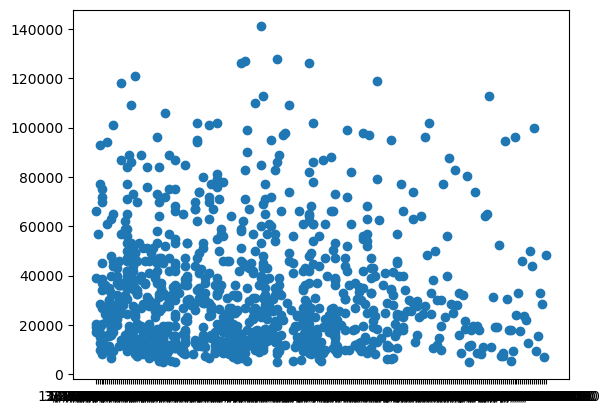

In [413]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

In [414]:
df.saledate[:1000]

0      11/16/2006 0:00
1       3/26/2004 0:00
2       2/26/2004 0:00
3       5/19/2011 0:00
4       7/23/2009 0:00
            ...       
995     7/16/2009 0:00
996     6/14/2007 0:00
997     9/22/2005 0:00
998     7/28/2005 0:00
999     6/16/2011 0:00
Name: saledate, Length: 1000, dtype: object

In [415]:
df.saledate.dtype

dtype('O')

<Axes: ylabel='Frequency'>

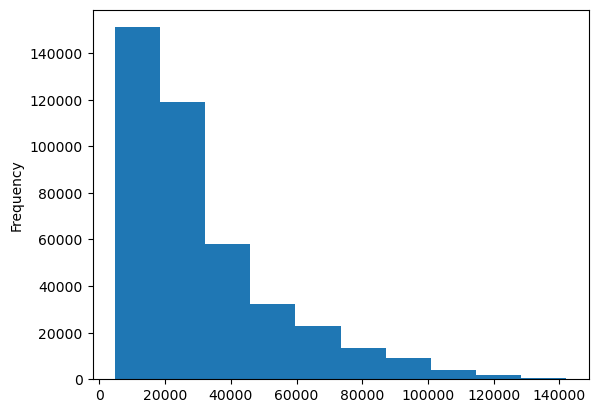

In [416]:
df.SalePrice.plot.hist()

## Parsing dates

When we work with time series data, we want to enrich the time & date component as much as possible.

We can do that by telling pandas which of our columns has dates in it using the `parse_dates` parameter. 

In [417]:
# Import data again but this time parse dates
df = pd.read_csv("Data/bluebook-for-bulldozers/TrainAndValid.csv", low_memory=False, parse_dates=["saledate"] )

In [418]:
df.saledate.dtype

dtype('<M8[ns]')

In [419]:
df.saledate[:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

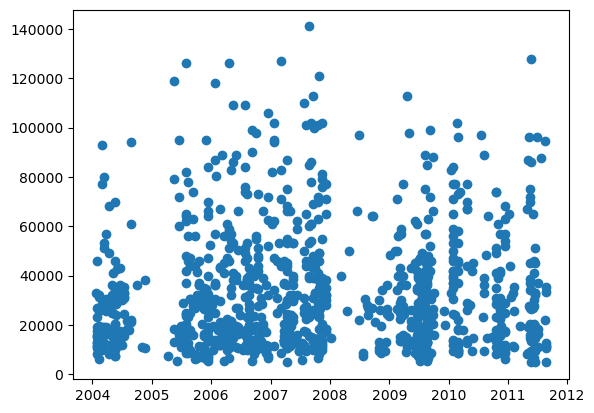

In [420]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

In [421]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [422]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [423]:
df.saledate.head(20)

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

### Sort DataFrame by saledate

When working with time series data, it's a good idea to sort it by date.

In [424]:
# Sort DataFrame in date order
df.sort_values(by=["saledate"], inplace=True, ascending=True)
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make a copy of the original DataFrame

We make a copy of the original DataFrame so when we manipulate the copy, we've still got our original data.

In [425]:
# Makee a copy
df_tmp = df.copy()

## Add datetime parameters for `saledate` column

In [426]:
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayOfWeek"] = df.saledate.dt.dayofweek
df_tmp["saleDayOfYear"] = df.saledate.dt.dayofyear

In [427]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [428]:
# Now we've enriched our DataFrame with date time featurs, we can remember saledate.
df_tmp.drop("saledate", axis=1, inplace=True)

In [429]:
# Check the values of different columns
df_tmp.state.value_counts()

state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virgi

In [430]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,...,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1,31


## 5. Modelling

We've done enough EDA (we could always do more) but let's start to do some model-driven EDA

In [431]:
len(df_tmp)

412698

In [432]:
# Let's build a machine learning model
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1, random_state=42)

model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"])

ValueError: could not convert string to float: 'Low'

In [433]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

In [434]:
df_tmp["UsageBand"].dtype

dtype('O')

In [435]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

### Convert string to categories

One way we can turn all of our data into numbers is by converting thm into pandas categories. We can check the different datatyps compatible with pandas here: https://pandas.pydata.org/pandas-docs/stable/reference/general_utility_functions.html#data-types-related-functionality

In [436]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [437]:
pd.api.types.is_object_dtype(df_tmp["UsageBand"])

True

In [438]:
# Find the columns which contain strings
for label, content in df_tmp.items():
    if pd.api.types.is_object_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [439]:
# If you're wondering what df.items() does, here's an example
random_dict = {"key1": "hello",
              "key2": "world!"}

for key, value in random_dict.items():
    print(f"this is a key: {key}",
         f"this is a value: {value}")

this is a key: key1 this is a value: hello
this is a key: key2 this is a value: world!


In [440]:
# Print column names and example content of columns which contain strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        # Check datatype of target column
        column_datatype = df_tmp[label].dtype.name

        # Get random sample from column values
        example_value = content.sample(1).values

        # Infer random sample datatype
        example_value_dtype = pd.api.types.infer_dtype(example_value)
        print(f"Column name: {label} | Column dtype: {column_datatype} | Example value: {example_value} | Example value dtype: {example_value_dtype}")

Column name: fiModelDesc | Column dtype: object | Example value: ['621B'] | Example value dtype: string
Column name: fiBaseModel | Column dtype: object | Example value: ['D4'] | Example value dtype: string
Column name: fiProductClassDesc | Column dtype: object | Example value: ['Wheel Loader - 120.0 to 135.0 Horsepower'] | Example value dtype: string
Column name: state | Column dtype: object | Example value: ['Mississippi'] | Example value dtype: string
Column name: ProductGroup | Column dtype: object | Example value: ['TTT'] | Example value dtype: string
Column name: ProductGroupDesc | Column dtype: object | Example value: ['Skid Steer Loaders'] | Example value dtype: string


In [441]:
# Start a count of how many object type columns there are
number_of_object_type_columns = 0

for label, content in df_tmp.items():
    # Check to see if column is of object type (this will include the string columns)
    if pd.api.types.is_object_dtype(content): 
        # Check datatype of target column
        column_datatype = df_tmp[label].dtype.name

        # Get random sample from column values
        example_value = content.sample(1).values

        # Infer random sample datatype
        example_value_dtype = pd.api.types.infer_dtype(example_value)
        print(f"Column name: {label} | Column dtype: {column_datatype} | Example value: {example_value} | Example value dtype: {example_value_dtype}")

        number_of_object_type_columns += 1

print(f"\n[INFO] Total number of object type columns: {number_of_object_type_columns}")

Column name: UsageBand | Column dtype: object | Example value: ['Medium'] | Example value dtype: string
Column name: fiModelDesc | Column dtype: object | Example value: ['PC150-5'] | Example value dtype: string
Column name: fiBaseModel | Column dtype: object | Example value: ['SE210'] | Example value dtype: string
Column name: fiSecondaryDesc | Column dtype: object | Example value: [nan] | Example value dtype: empty
Column name: fiModelSeries | Column dtype: object | Example value: [nan] | Example value dtype: empty
Column name: fiModelDescriptor | Column dtype: object | Example value: [nan] | Example value dtype: empty
Column name: ProductSize | Column dtype: object | Example value: [nan] | Example value dtype: empty
Column name: fiProductClassDesc | Column dtype: object | Example value: ['Wheel Loader - 100.0 to 110.0 Horsepower'] | Example value dtype: string
Column name: state | Column dtype: object | Example value: ['Texas'] | Example value dtype: string
Column name: ProductGroup 

In [442]:
# This will turn all of the string/object values into category values

for label, content in df_tmp.items():
    if pd.api.types.is_object_dtype(content):
        df_tmp[label] = df_tmp[label].astype("category") #Use astype() for type conversion
        

In [443]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor         748

In [444]:
df_tmp.state.dtype

CategoricalDtype(categories=['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
                  'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia',
                  'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
                  'Kentucky', 'Louisiana', 'Maine', 'Maryland',
                  'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
                  'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
                  'New Jersey', 'New Mexico', 'New York', 'North Carolina',
                  'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
                  'Puerto Rico', 'Rhode Island', 'South Carolina',
                  'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah',
                  'Vermont', 'Virginia', 'Washington', 'Washington DC',
                  'West Virginia', 'Wisconsin', 'Wyoming'],
, ordered=False, categories_dtype=object)

In [445]:
# Just checking (optional)
pd.api.types.is_string_dtype(df_tmp["state"])

True

In [446]:
# Get the category names of a given column
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [447]:
# Inspect the cateegory codes
df_tmp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

#### This gives us a numeric representation of our object/string columns.

In [448]:
# Get example string using category number
target_state_cat_number = 43
target_state_cat_value = df_tmp.state.cat.categories[target_state_cat_number]
print(f"[INFO] Target state category number {target_state_cat_number} maps to: {target_state_cat_value}")

[INFO] Target state category number 43 maps to: Texas


All of our data is now categorical and we can now turn the categories into numbers. However, it's still missing values but we will remedy that.

### Save our preprocessed data (Part 1)

Before we start doing any further preprocessing steps on our DataFrame, we should save our current DataFrame to file so we could import it again later if necessary.

Saving and updating your dataset as you go is common practice in machine learning problems. As your problem changees and evolves, the dataset you're working with will likely change too.

Making checkpoints of your dataset is similar to making checkpoints of your code.

In [449]:
# Save preprocessed data to file
df_tmp.to_csv("Data/bluebook-for-bulldozers/TrainAndValid_object_values_as_categories.csv", index=False)

Now we've saved our preprocessed data to file, we can re-import it and make sure it's in the same format.

In [450]:
# Import preprocessed data to file
df_tmp = pd.read_csv("Data/bluebook-for-bulldozers/TrainAndValid_object_values_as_categories.csv", low_memory=False)

df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
0,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
1,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
2,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31
3,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
4,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,...,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1,31


Looking at the tail end (far right side) our processed DataFrame has the columns wee added to it (extra data features) but it's still missing values.

Let's check using `df_tmp.info()`

In [451]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-null   o

Notice that our category datatype columns are back to being the object datatype.

This is strange since we already converted the object datatype columns to category.

Well then why did it change back?

Explanation: This happens because of the limitations of the CSV (.csv) file format, it doesn't preserve datatypes, rather it stores all th values as strings.

So when we read in a CSV, panda defaults to interpreting strings as object datatypes.

There's a way to convert them to the category datatype as we did before.

>> Note: If you'd like to retain the datatypes when saving your data, you can use file formats such as `parquet` (Apache Parquet) and `feather`. These filetypes have several advantages over CSV in terms of processing speeds and storage size. However, data stored in these formats is not human readable so you won't be able to open the files and inspect them without specific tools. For more on different file formats in pandas, see the IO tools documentation page: https://pandas.pydata.org/docs/user_guide/io.html#

In [452]:
for label, content in df_tmp.items():
    if pd.api.types.is_object_dtype(content):
        #Turn object columns into category datatype
        df_tmp[label] = df_tmp[label].astype("category")

Now if we wanted to preserve the datatypes of our data, we can save to parquet or feather format.

Let's try using parquet.

To do so, we can use the `pandas.DataFrame.to_parquet()` method.

Files in the `parquet` format typically have the file extension of `.parquet`.

In [453]:
# To save to parqueet format requires pyarror or fastparquet (or both)
# Can install via `pip install pyarrow fastparquet`
df_tmp.to_parquet("Data/bluebook-for-bulldozers/TrainAndValid_object_values_as_categories.parquet", engine="auto")
# auto will automatically use pyarrow or fastparquet, defaulting to pyarrow first

Let's try importing our DataFrame from the parquet format and check it using `df_tmp.info()`

In [454]:
# Read in df_tmp from parquet format
df_tmp = pd.read_parquet(path="Data/bluebook-for-bulldozers/TrainAndValid_object_values_as_categories.parquet", engine="auto")

# Using parquet format, datatypes are preserved
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor         748

## Finding and Filling Missing Values

Let's remind ourselves of the missing values by getting the top 20 columns with the most missing values.

We do so by summing the results of `pandas.DataFrame.isna()` and then using `sort_values(ascending=False)` to showcase the rows with the most missing values.

In [455]:
# Check missing values
df_tmp.isna().sum().sort_values(ascending=False)[:20]

Blade_Width          386715
Engine_Horsepower    386715
Tip_Control          386715
Pushblock            386715
Blade_Extension      386715
Enclosure_Type       386715
Scarifier            386704
Hydraulics_Flow      367823
Grouser_Tracks       367823
Coupler_System       367724
fiModelSeries        354031
Steering_Controls    341176
Differential_Type    341134
UsageBand            339028
fiModelDescriptor    337882
Backhoe_Mounting     331986
Stick                331602
Turbocharged         331602
Pad_Type             331602
Blade_Type           330823
dtype: int64

There are a few columns with missing values and there are several datatypes across these columns (numerical & categorical). 

Let's break the problem down and work on filling each datatype separately.

# Filling Missing Numerical Values

There's no set way to fill missing values in your dataset.

And unless you're filling the missing samples with newly discovered actual data, every way you fill your dataset's missing valus will introduce somee noise or bias.

We'll start by filling the missing numerical values in our dataset.

To do this, we'll first find the numeric datatype columns.

We can do this by looping through the columns in our DataFrame and calling `pd.api.types.is_numeric_dtype(arr_or_dtype)` on them.


In [456]:
# Find numeric columns

for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        # Check datatype of target column
        column_datatype = df_tmp[label].dtype.name

        #Get random sample from column values
        example_value = content.sample(1).values

        #Infer random sample datatype
        example_value_dtype = pd.api.types.infer_dtype(example_value)
        print(f"Column name: {label} | Column dtype: {column_datatype} | Example value: {example_value} | Example value dtype: {example_value_dtype}")
        

Column name: SalesID | Column dtype: int64 | Example value: [2649346] | Example value dtype: integer
Column name: SalePrice | Column dtype: float64 | Example value: [40500.] | Example value dtype: floating
Column name: MachineID | Column dtype: int64 | Example value: [1134395] | Example value dtype: integer
Column name: ModelID | Column dtype: int64 | Example value: [15384] | Example value dtype: integer
Column name: datasource | Column dtype: int64 | Example value: [132] | Example value dtype: integer
Column name: auctioneerID | Column dtype: float64 | Example value: [9.] | Example value dtype: floating
Column name: YearMade | Column dtype: int64 | Example value: [1985] | Example value dtype: integer
Column name: MachineHoursCurrentMeter | Column dtype: float64 | Example value: [0.] | Example value dtype: floating
Column name: saleYear | Column dtype: int64 | Example value: [2011] | Example value dtype: integer
Column name: saleMonth | Column dtype: int64 | Example value: [9] | Exampl

We've got a mix of numerical datatypes.

Let's find out which numeric columns are missing values.

We can do so by using `pandas.isnull(obj).sum()` to detect and sum the missing values in a given array-like object (in our case, the data in a target column).

Let's loop through our DataFrame columns, find the numeric datatypes and check if they have any missing values.

In [457]:
# Check for which numeric columns have null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(f"Column name: {label} | Has missing values: {True}")
        else:
            print(f"Column name: {label} | Has missing values: {False}")

Column name: SalesID | Has missing values: False
Column name: SalePrice | Has missing values: False
Column name: MachineID | Has missing values: False
Column name: ModelID | Has missing values: False
Column name: datasource | Has missing values: False
Column name: auctioneerID | Has missing values: True
Column name: YearMade | Has missing values: False
Column name: MachineHoursCurrentMeter | Has missing values: True
Column name: saleYear | Has missing values: False
Column name: saleMonth | Has missing values: False
Column name: saleDay | Has missing values: False
Column name: saleDayOfWeek | Has missing values: False
Column name: saleDayOfYear | Has missing values: False


`auctioneerID` and `MachineHoursCurrentMeter` columns have missing numeric values.

Let's have a look at how we might handle these.

## Discussing Possible Ways to Handle Missing Values

as previously discussed, there are many ways to fill missing values. For missing numeric values, some potential options are:

### Fill with mean of column	

PROS
- Easy to calculate/implement
- Retains overall data distribution

CONS
- Averages out variation
- Affected by outliers (e.g. if one value is much higher/lower than others)


### Fill with median of column	

PROS
- Easy to calculate/implement
- Robust to outliers
- Preserves center of data

CONS
- Ignores data distribution shape

  
### Fill with mode of column	

PROS
- Easy to calculate/implement
- More useful for categorical-like data

CONS
- May not make sense for continuous/numerical data

  
### Fill with 0 (or another constant)

PROS
- Simple to implement
- Useful in certain contexts like counts

CONS
- Introduces bias (e.g. if 0 was a value that meant something)
- Skews data (e.g. if many missing values, replacing all with 0 makes it look like that's the most common value)


### Forward/Backward fill (use previous/future values to fill future/previous values)

PROS
- Maintains temporal continuity (for time series)

  
CONS
- Assumes data is continuous, which may not be valid


### Use a calculation from other columns	

PROS
- Takes existing information and reinterprets it

CONS
- Can result in unlikely outputs if calculations are not continuous


### Interpolate (e.g. like dragging a cell in Excel/Google Sheets)	

PROS
- Captures trends
- Suitable for ordered data

CONS
- Can introduce errors
- May assume linearity (data continues in a straight line)


### Drop missing values	

PROS
- Ensures complete data (only use samples with all information)
- Useful for small datasets

CONS
- Can result in data loss (e.g. if many missing values are scattered across columns, data size can be dramatically reduced)
- Reduces dataset size

Which method you choose will be dataset and problem dependent and will likely require several phases of experimentation to see what works and what doesn't.

For now, we'll fill our missing numeric valyues with the median value of the target column.

We'll also add a binary column (0 or 1) with rows reflecting whether or not a value was missing.

For example, `MachineHoursCurrentMeter_is_missing` will be a column with rows which have a value of 0 if that row's `MachineHoursCurrentMeter` column was not missing and 1 if it was.

In [458]:
# Fill missing numeric values with the median of the target column
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells if the data was missing or not
            df_tmp[label+"_is_missing"] = pd.isnull(content).astype(int) # this will add a 0 or 1 value to rows with missing values (0 = not missing, 1 = missing)
            # Fill missing numeric values with median since it's more robust than the mean
            df_tmp[label] = content.fillna(content.median())

Why add a binary column indicating whether the data was missing or not?

We can easily fill all of the missing numeric values in our dataset with the median

However, a numeric value may be missing for a reason.

Adding a binary column which indicates whether the value was missing or not helps to retain this information. It also means we cna inspect these rows later on.

In [459]:
# Show rows where MachineHoursCurrentMeter_is_missing == 1
df_tmp[df_tmp["MachineHoursCurrentMeter_is_missing"] == 1].sample(5)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear,auctioneerID_is_missing,MachineHoursCurrentMeter_is_missing
368526,1585492,30000.0,1344326,4667,132,4.0,2000,0.0,NaN,450LC,...,NaN,NaN,NaN,2011,2,7,0,38,0,1
225464,1607041,32000.0,1391743,4700,132,1.0,1993,0.0,NaN,544G,...,NaN,Standard,Conventional,2007,3,30,4,89,0,1
212922,1332839,18000.0,1466537,1092,132,4.0,1993,0.0,NaN,307SSR,...,NaN,NaN,NaN,2006,11,2,3,306,0,1
160932,1472801,15750.0,1311445,7511,132,4.0,1990,0.0,NaN,E70,...,NaN,NaN,NaN,2004,4,17,5,108,0,1
112992,1662992,24500.0,1281929,4991,132,2.0,1998,0.0,NaN,555E,...,NaN,NaN,NaN,2001,6,9,5,160,0,1


The missing numeric values have been filled.

Let's check again whether or not the numeric columns have missing values?

In [460]:
for label, content, in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(f"Column name: {label} | Has missing value: {True}")
        else:
            print(f"Column name: {label} | Has missing values: {False}")

Column name: SalesID | Has missing values: False
Column name: SalePrice | Has missing values: False
Column name: MachineID | Has missing values: False
Column name: ModelID | Has missing values: False
Column name: datasource | Has missing values: False
Column name: auctioneerID | Has missing values: False
Column name: YearMade | Has missing values: False
Column name: MachineHoursCurrentMeter | Has missing values: False
Column name: saleYear | Has missing values: False
Column name: saleMonth | Has missing values: False
Column name: saleDay | Has missing values: False
Column name: saleDayOfWeek | Has missing values: False
Column name: saleDayOfYear | Has missing values: False
Column name: auctioneerID_is_missing | Has missing values: False
Column name: MachineHoursCurrentMeter_is_missing | Has missing values: False


The numeric missing values have been filled!

Thanks to our binary `_is_missing columns`, we can even check how many were missing.

In [461]:
# Check to see how many examples in the auctioneerID were missing
df_tmp.auctioneerID_is_missing.value_counts()

auctioneerID_is_missing
0    392562
1     20136
Name: count, dtype: int64

# Filling Missing Categorical Values with Pandas

Now we've filled the numeric values, we'll do the same with the categorical values while ensuring they are all numerical too.

Let's investigate the columns which aren't numeric (we've already worked with these).

In [462]:
# Check columns which aren't numeric
print(f"[INFO] Columns which are not numeric:")
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(f"Column name: {label} | Column dtype: {df_tmp[label].dtype.name}")

[INFO] Columns which are not numeric:
Column name: UsageBand | Column dtype: category
Column name: fiModelDesc | Column dtype: category
Column name: fiBaseModel | Column dtype: category
Column name: fiSecondaryDesc | Column dtype: category
Column name: fiModelSeries | Column dtype: category
Column name: fiModelDescriptor | Column dtype: category
Column name: ProductSize | Column dtype: category
Column name: fiProductClassDesc | Column dtype: category
Column name: state | Column dtype: category
Column name: ProductGroup | Column dtype: category
Column name: ProductGroupDesc | Column dtype: category
Column name: Drive_System | Column dtype: category
Column name: Enclosure | Column dtype: category
Column name: Forks | Column dtype: category
Column name: Pad_Type | Column dtype: category
Column name: Ride_Control | Column dtype: category
Column name: Stick | Column dtype: category
Column name: Transmission | Column dtype: category
Column name: Turbocharged | Column dtype: category
Column n

There are many category type columns. 

Let's now write come code to fill the missing categorical values as well as ensure they are numerical (non-string)

To do so, we'll

1. Create a blank column to category dictionary, we'll use this to store categorical value names (e.g. their string name) as well as their categorical code. We'll end with a dictionary of dictionaries in the form {"column_name": {category_code: "category_value"...}...}.
2. Loop through the items in the DataFrame.
3. Check if the column is numeric or not.
4. Add a binary column in the form ORIGINAL_COLUMN_NAME_is_missing with a 0 or 1 value for if the row had a missing value.
5. Ensure the column values are in the pd.Categorical datatype and get their category codes with pd.Series.cat.codes (we'll add 1 to these values since pandas defaults to assigning -1 to NaN values, we'll use 0 instead).
6. Turn the column categories and column category codes from 5 into a dictionary with Python's dict(zip(category_names, category_codes)) and save this to the blank dictionary from 1 with the target column name as key.
7. Set the target column value to the numerical category values from 5.

In [463]:
# 1. Create a dictionary to store column to category values (we turn our category into numbers but we keep a record so we can go back
column_to_category_dict = {}

#2. Turn categorical variables into numbers
for label, content in df_tmp.items():
    #3. Check columns which aren't numeric
    if not pd.api.types.is_numeric_dtype(content):
        #4. Add a binary column to indicate whether sample had missing value
        df_tmp[label+"_is_missing"] = pd.isnull(content).astype(int)
        #5. Ensure content is categorical and get its category codes
        content_categories = pd.Categorical(content)
        content_category_codes = content_categories.codes + 1 # prevents -1 (the default for NaN values) from being used for missing values (we'll treat missing values as 0)
        #6. Add column key to dictionary with code: category mapping per column
        column_to_category_dict[label] = dict(zip(content_category_codes, content_categories))
        #7. Set the column to the numerical values (the category code value)
        df_tmp[label] = content_category_codes
                                                
    

Let's check out a few random samples of our DataFrame.

In [464]:
df_tmp.sample(5)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
106573,1659330,19500.0,1245876,4991,132,1.0,1998,0.0,0,1030,...,1,1,1,1,1,1,1,1,1,1
296188,4408329,8500.0,1207048,12524,172,1.0,2004,2468.0,3,4550,...,0,0,0,0,0,1,1,1,1,1
122529,1266209,34000.0,1486751,3178,132,2.0,1996,0.0,0,1092,...,1,1,1,1,1,1,1,1,1,1
368124,2631013,22000.0,1511101,1861,149,4.0,2002,0.0,0,867,...,1,1,1,1,1,0,0,0,1,1
291950,2292577,28000.0,733156,3539,136,8.0,2002,0.0,0,749,...,1,1,1,1,1,1,1,1,1,1


Our data is now all in numerical form.

Let's investigate an item from `column_to_category_dict`

This will show the mapping from numerical value to category (most likely a string) value.

In [465]:
# Check the UsageBand (measure of bulldozer usage)
for key, value in sorted(column_to_category_dict["UsageBand"].items()): #Note: calling sorted() on dictionary.items() sorts the dictionary by keys
    print(f"{key} -> {value}")

0 -> nan
1 -> High
2 -> Low
3 -> Medium


Note: Categorical values do not necessarily have order. They are strictly mapping from number to value. In this case, our categorical values are mapped in numerical order. If you feel that the order of a value may influence a model in a negative way (1 -> high is lower than 3 -> medium but should be higher), you may want to look into ordering the values in a particular way or using a different numerical encoding technique such as one-hot coding: https://en.wikipedia.org/wiki/One-hot

We can do the same for the `state` column values.

In [466]:
# Check the first 1- state column values
for key, value in sorted(column_to_category_dict["state"].items())[:10]:
    print(f"{key} -> {value}")

1 -> Alabama
2 -> Alaska
3 -> Arizona
4 -> Arkansas
5 -> California
6 -> Colorado
7 -> Connecticut
8 -> Delaware
9 -> Florida
10 -> Georgia


Before we build our model, let's check to see if all missing values have been filled?

In [467]:
# Check total number of missing vlaues
total_missing_values = df_tmp.isna().sum().sum()

if total_missing_values == 0:
    print(f"[INFO] Total missing values: {total_missing_values} - Let's go build our machine learning model!")
else:
    print(f"[INFO] Uh ohh... total missing values: {total_missing_values} - Something went wrong, let's go back and fill the values.")

[INFO] Total missing values: 0 - Let's go build our machine learning model!


# Saving our preprocessed data (Part 2)

One more step before we train a new model.

Let's save our work so far so we could re-import our preprocessed dataseet if we wanted to.

We'll save it to the `parquet` format again, this time with a suffix to show we've filled the missing values.


In [468]:
# Save preprocessed data with object values as categories as well as missing values filled
df_tmp.to_parquet(path="Data/bluebook-for-bulldozers/TrainAndValid_object_values_as_categories_and_missing_values_filled.parquet", engine="auto")

And to make sure it works, let's reimport it.

In [469]:
# Read in preprocessed dataset
df_tmp = pd.read_parquet(path="Data/bluebook-for-bulldozers/TrainAndValid_object_values_as_categories_and_missing_values_filled.parquet", engine="auto")

Let's double check for missing values.

In [470]:
# Check total number of missing values
total_missing_values = df_tmp.isna().sum().sum()

if total_missing_values == 0:
    print(f"[INFO] Total missing values: {total_missing_values} - Woohoo! Let's build a model!")
else:
    print(f"[INFO] Uh ohh... total missing values: {total_missing_values} - Perhaps we might have to retrace our steps to fill the values?")

[INFO] Total missing values: 0 - Woohoo! Let's build a model!


We've hit our checkpoint!

We've turned all of our data into numbers as well as filled the missing values, time to try fitting a model to it again.

# Fitting a Machine Learning Model to our Preprocessed Data

Now all of our data is numeric and there are no missing values, we should be able to fit a machine learning model to it!

Let's reinstantiate our trusty sklearn.ensemble.RandomForestRegressor model.

Since our dataset has a substantial amount of rows (~400k+), let's first make sure the model will work on a smaller sample of 1000 or so.

> Note: It's common practice on machine learning problems to see if your experiments will work on smaller scale problems (e.g. smaller amounts of data) before scaling them up to the full dataset. This practice enables you to try many different kinds of experiments with faster runtimes. The benefit of this is that you can figure out what doesn't work before spending more time on what does.

Our X values (features) will be every column except the SalePrice column.

And our y values (labels) will be the entirety of the SalePrice column.

We'll time how long our smaller experiment takes using the magic function %%time and placing it at the top of the notebook cell.

> Note: You can find out more about the %%time magic command by typing %%time? (note the question mark on the end) in a notebook cell.

In [471]:
%%time

# Sample 1000 samples with random state 42 for reproducibility
df_tmp_sample_1k = df_tmp.sample(n=1000, random_state=42)

#Instantiate a model
model = RandomForestRegressor(n_jobs=-1) #use -1 to utilize all available processors

# Create features and labels
X_sample_1k = df_tmp_sample_1k.drop("SalePrice", axis=1) #Use all columns except SalePrice
y_sample_1k = df_tmp_sample_1k["SalePrice"] #Use SalePrice as y values (target variable)

#Fit the model to the sample data
model.fit(X=X_sample_1k, y=y_sample_1k)

CPU times: total: 1.91 s
Wall time: 257 ms


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


This is relatively quick because we're only using a relatively small number of rows. 

Let's score our model using the built-in method `score()`.

By default, `sklearn.ensemble.RandomForestRegressor` use the coefficient of determination R-squared as the evaluation metric (higher is better, with a score of 1.0 being perfect)

In [472]:
# Evaluate the model
model_sample_1k_score = model.score(X=X_sample_1k, y=y_sample_1k)

print(f"[INFO] Model score on {len(df_tmp_sample_1k)} samples: {model_sample_1k_score}")

[INFO] Model score on 1000 samples: 0.9569172558862359


This is looking promising, with a good score on only 1000 samples (the best possible score it could have achieved would have been 1.0)

Let's try our model on the whole dataset.

In [473]:
%%time 

#Instantiate model
model = RandomForestRegressor(n_jobs=-1) #note: this could take quite a while depending on your machine

#Create features and labels with entire dataset
X_all = df_tmp.drop("SalePrice", axis=1)
y_all = df_tmp["SalePrice"]

# Fit the model
model.fit(X=X_all, y=y_all)

CPU times: total: 29min 18s
Wall time: 2min 20s


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


This took longer than fitting on 1000 samples because many more calculations had to be made.

There's a reason why `n_jobs=-1` is used as well.

If we stuck with the default of `n_jobs=None` (the same as n_jobs=1), it would have taken much longer.

One of the most important main goals when starting a machine learning project is to reduce your time between experiments.

How about we see the score of the model trained on all of the data?

In [474]:
# Evaluate the modeel
model_sample_all_score = model.score(X=X_all, y=y_all)

print(f"[INFO] Model score on {len(df_tmp)} samples: {model_sample_all_score}")

[INFO] Model score on 412698 samples: 0.9875580886915061


Do not be misled by this high score, no model is supposed to be exactly nearly perfect.

# Troubleshooting: A big but fixable mistake

One of the hard things about bugs in machine learning projects is that they are often silent. 

For example, the model seems to have fit the data with no issues and then evaluated with a good score.

What's the issue?

It seems we've stumbled across of the most common bugs in machine learning and that is <b>data leakage<b> (data from the training set leaking into the validation/testing sets).

We've evaluated our model on the same data it was trained on and this isn't the model's fault either.

It's our fault.

Right back at the start we imported a file called TrainAndValid.csv, this contains both the training and validation data.

And while we preprocessed it to make sure there were no missing values and the samples were all numeric, we never split the data into separate training and validation splits.

The right workflow would've been to train the model on the training split and then evaluate it on the unseen validation split.

Our evaluation scores above are quite good but they can't necessarily be trusted to be replicated on unseen data (data in the real world) because they've been obtained by evaluating the model on data its already seen.

This would be the equivalent of a final exam at university containing all of the same questions as the practice exam without any changes.

Not to worry, we can fix this!

How?

We can import the training and validation datasets separately via Train.csv and Valid.csv respectively.

Or we could import TrainAndValid.csv and perform the appropriate splits according the original Kaggle competition page (training data includes all samples prior to 2012 and validation data includes samples from January 1 2012 to April 30 2012).

In both methods, we'll have to perform the same preprocessing steps we've done so far.

Except because the validation data is supposed to remain as unseen data, we'll only use information from the training set to preprocess the validation set (and not mix the two).

We'll work on this in the next section.

The takeaway?

Always (if possible) create appropriate data splits at the start of a project.

Because it's one thing to train a machine learning model but if you can't evaluate it properly (on unseen data), how can you know how it'll perform (or may perform) in the real world on new and unseen data?

# TK - Splitting data into train/valid sets

TK - trying to fit a model forced us to prepare our dataset in a way that it could be used with a model but caused us to make the mistake of mixing the training/validation data (perhaps this was on purpose...)

TK - can just import the Train/Valid CSVs separately and fill with Scikit-Learn imputers

Good new is, we get to practice preprocessing our data again. This time with separate training and validation splits. Last time we used pandas to make ensure our data was all numeric and had no missing values. But using pandas in this way can be a bit of an issue with larger scale datasets or when new data is introduced. How about this time we use Scikit-Learn and make a reproducible pipeline for our data preprocessing needs?

Next steps:

- import train/validation data separately
- create scikit-learn data filling pipeline for fitting to training data (turn all data numeric + fill missing values)
- use this preprocessing pipeline for applying to to validation data (e.g. fit_transform on train data -> only transform on validation data)
- eval + improve on validation data
- We imported the TrainAndValid.csv and filled missing values/evaluated on it already

In [475]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,1,1,1,1,1,0,0,0,1,1
1,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,...,1,1,1,1,1,1,1,1,0,0
2,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,...,1,1,1,1,1,0,0,0,1,1
3,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,...,1,1,1,1,1,1,1,1,0,0
4,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,...,1,1,1,1,1,0,0,0,1,1


According to the Kaggle data page, the validation set and test set are split according to dates.

This makes sense since we're working on a time series problem.

E.g. using past events to try and predict future events.

Knowing this, randomly splitting our data into train and test sets using something like train_test_split() wouldn't work.

Instead, we split our data into training, validation and test sets using the date each sample occured.

In our case:

Training = all samples up until 2011
Valid = all samples form January 1, 2012 - April 30, 2012
Test = all samples from May 1, 2012 - November 2012
For more on making good training, validation and test sets, check out the post How (and why) to create a good validation set by Rachel Thomas.

https://www.fast.ai/2017/11/13/validation-sets/

In [476]:
df_tmp.saleYear.value_counts()

saleYear
2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: count, dtype: int64

In [477]:
# Split data into training and validation sets
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

len(df_val), len(df_train)

(11573, 401125)

In [478]:
# Split data into X & y
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val.SalePrice

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape


((401125, 102), (401125,), (11573, 102), (11573,))

# Building an evaluation function

According to Kaggle for the Bulldozers competition, the evaluation function they use is root mean squared log error (RMSLE).

RMSLE = generally you don't care as much if you're off by $10 as much as you'd care if you were off by 10%, you care more about ratios rather than differences. MAE (mean absolute error) is more about exact differences.

It's important to understand the evaluation metric you're going for.

Since Scikit-Learn doesn't have a function built-in for RMSLE, we'll create our own.

We can do this by taking the square root of Scikit-Learn's mean_squared_log_error (MSLE). MSLE is the same as taking the log of mean squared error (MSE).

We'll also calculate the MAE and R^2 for fun.

TK - use RMSLE from scikit-learn, see: https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.root_mean_squared_log_error.html#sklearn.metrics.root_mean_squared_log_error

In [479]:
# Create evaluation function (the competition uses Root Mean Square Log Error)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error

# can now use RMSLE from scikit-learn
def rmsle(y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate our model
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": model.score(X_train, y_train),
              "Valid R^2": model.score(X_valid, y_valid)}
    return scores

## Testing our model on a subset (to tune the hyperparameters)

In [480]:
# This takes far too long

#model = RandomForestRegressor(n_jobs=-1, random_state=42)

#model.fit(X_train, y_train)

In [481]:
len(X_train)

401125

In [482]:
# Change max_samples value
model = RandomForestRegressor(n_jobs=-1, random_state=42, max_samples=10000)

model

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [483]:
%%time

# Cutting down on the max number of samples each estimator can see improves training time
model.fit(X_train, y_train)

CPU times: total: 55.2 s
Wall time: 4.93 s


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [484]:
X_train.shape[0] * 100

40112500

In [485]:
show_scores(model)

{'Training MAE': 5561.298809224058,
 'Valid MAE': 7177.26365505919,
 'Training RMSLE': np.float64(0.25774537825697696),
 'Valid RMSLE': np.float64(0.29362638671089003),
 'Training R^2': 0.8606658995199188,
 'Valid R^2': 0.8320374995090507}

# Hyperparameter tuning with RandomizedSearchCV

In [486]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid = {"n_estimators": np.arange(10,100,10),
          "max_depth": [None, 3,5,10],
          "min_samples_split": np.arange(2,20,2),
          "min_samples_leaf": np.arange(1,20,2),
          "max_features": [0.5, 1, "sqrt", "auto"],
          "max_samples": [10000]}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42), param_distributions=rf_grid, n_iter=2, cv=5, verbose=True)

#Fit the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: total: 1min 1s
Wall time: 10.1 s


,estimator,RandomForestR...ndom_state=42)
,param_distributions,"{'max_depth': [None, 3, ...], 'max_features': [0.5, 1, ...], 'max_samples': [10000], 'min_samples_leaf': array([ 1, 3..., 15, 17, 19]), ...}"
,n_iter,2
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,True
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [487]:
# Find the best model hyperparameters
rs_model.best_params_

{'n_estimators': np.int64(80),
 'min_samples_split': np.int64(2),
 'min_samples_leaf': np.int64(11),
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': 3}

In [488]:
show_scores(rs_model)

{'Training MAE': 11803.799299011813,
 'Valid MAE': 13506.587409021698,
 'Training RMSLE': np.float64(0.5068958737088659),
 'Valid RMSLE': np.float64(0.5124269696841944),
 'Training R^2': 0.4888763252189847,
 'Valid R^2': 0.48941848217422346}

### Train a model with the best hyperparameters

**Note:** These were found after 100 iterations of `RandomizedSearchCV`.

In [489]:
%%time

#Most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=40, min_samples_leaf=1, min_samples_split=14, max_features=0.5, n_jobs=-1, max_samples=None, random_state=42) #random state so our results are reproducable

# Fit the ideal model
ideal_model.fit(X_train, y_train)

CPU times: total: 5min 23s
Wall time: 27.3 s


,n_estimators,40
,criterion,'squared_error'
,max_depth,None
,min_samples_split,14
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,0.5
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [490]:
# Scores for ideal_model (trained on all data)
show_scores(ideal_model)

{'Training MAE': 2953.816113716348,
 'Valid MAE': 5951.247761444453,
 'Training RMSLE': np.float64(0.14469006962371855),
 'Valid RMSLE': np.float64(0.2452416398953833),
 'Training R^2': 0.9588145522577225,
 'Valid R^2': 0.8818019502450093}

In [491]:
# Scores on rs_model (only trained on ~10,000 examples)
show_scores(rs_model)

{'Training MAE': 11803.799299011813,
 'Valid MAE': 13506.587409021695,
 'Training RMSLE': np.float64(0.5068958737088659),
 'Valid RMSLE': np.float64(0.5124269696841944),
 'Training R^2': 0.4888763252189847,
 'Valid R^2': 0.48941848217422357}

## Make predictions on test data

In [492]:
# Import the test data
df_test = pd.read_csv("Data/bluebook-for-bulldozers/Test.csv", parse_dates=["saledate"])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [493]:
# Make predictions on the test dataset
test_preds = ideal_model.predict(df_test)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- saledate
Feature names seen at fit time, yet now missing:
- Backhoe_Mounting_is_missing
- Blade_Extension_is_missing
- Blade_Type_is_missing
- Blade_Width_is_missing
- Coupler_System_is_missing
- ...


The test data isn't in the same format as our other data, so we have to fix it.

## Preprocessing the test data

Our model has ben trained on data formatted in the same way as the training data. 

This means in order to make predictions on the test data, we need to take the same steps we used to preprocess th training data to preprocess the test data.

Important tip: Whatever you to the training data, you have to do to the test data.

Let's create a function for doing so by copying the preprocessing steps we used above.

In [494]:
def preprocess_data(df):
    """
    Performs transformations on df and returns transformed df.
    """
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayOfWeek"] = df.saledate.dt.dayofweek
    df["saleDayOfYear"] = df.saledate.dt.dayofyear
    
    df.drop("saledate", axis=1, inplace=True)
    
    # Fill the numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column which tells us if the data was missing or not
                df[label+"_is_missing"] = pd.isnull(content)
                # Fill missing numeric values with median
                df[label] = content.fillna(content.median())
    
        # Filled categorical missing data and turn categories into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            # We add +1 to the category code because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1
    
    return df



Question: Where would this function break?

Hint: What if the test data had different missing values to the training data?

Now we've got a function for preprocessing data, let's preprocess the test dataset into the same format as our training dataset.

In [495]:
df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [496]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,1,1,1,1,1,0,0,0,1,1
1,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,1,1,1,1,1,1,1,1,0,0
2,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,1,1,1,1,1,0,0,0,1,1
3,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,1,1,1,1,1,1,1,1,0,0
4,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,...,1,1,1,1,1,0,0,0,1,1


In [497]:
# Make predictions on the test dataset using the best model
test_preds = ideal_model.predict(df_test)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- auctioneerID_is_missing


This error is caused because our test dataset (after preprocessing) has 101 columns whereas our training dataset (X_train) has 102 columns after preprocessing

Let's spot the difference

In [498]:
# We can find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In this case, it's because the test dataset wasn't missing any `auctioneerID` fields.

To fix it, we'll add a column to the test dataset called `auctioneerID_is_missing` and fill it with False, since none of the auctioneerID fields are missing in the test dataset

In [499]:
# Match test dataset columns to training dataset
df_test["auctioneerID_is_missing"] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


There's one more step we have to do before we can make predictions on the test data. And that's to line up the columns (the features) in our test dataset to match the columns in our training dataset. 

Meaning, the order of the columns in the training dataset, should match the order of the columns in our test dataset.

> Note: As of scikit-learn 1.2, the order of columns that wer fit on should match the order of columns that are predicted on.

In [500]:
# Match column order from X_tran to df_test (to predict on columns, they should be in th same order they were fit on)
df_test = df_test[X_train.columns]

Now the test dataset column names and column order matches the training dataset, we should be able to make predictions on it using our trained model.

In [501]:
# Make predictions on the test dataset using the best model
test_preds = ideal_model.predict(df_test)

When looking at the Kaggle submission requirements, we see that if we wanted to make a submission, the data is required to be in a certain format. Namely, a DataFrame containing the SalesID and the predicted SalePrice of the bulldozer.

In [503]:
# Create DataFrame compatible with Kaggle submission requirements
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalePrice"] = test_preds
df_preds

,SalesID,SalePrice
0,1227829,17030.009274
1,1227844,14355.535652
2,1227847,46623.087743
3,1227848,71680.261335
4,1227863,61762.999424
...,...,...
12452,6643171,39966.363007
12453,6643173,12049.704433
12454,6643184,11964.850733
12455,6643186,16496.710793


In [504]:
## time to export
df_preds.to_csv("Data/bluebook-for-bulldozers/predictions.csv",index=False)

# Feature Importance

Since we've built a model which is able to make predictions. The people you share these predictions with (or yourself) might be curious of what parts of the data led to these predictions.

This is where feature importance comes in. Feature importance seeks to figure out which different attributes of the data were most important when it comes to predicting the target variable.

In our case, after our model learned the patterns in the data, which bulldozer sale attributes were most important for predicting its overall sale price?

Beware: the default feature importances for random forests can lead to non-ideal results.

To find which features were most important of a machine learning model, a good idea is to search something like "[MODEL NAME] feature importance".

Doing this for our RandomForestRegressor leads us to find the feature_importances_ attribute.

Let's check it out.

In [507]:
# Find feature importance of our best model
ideal_model.feature_importances_

array([3.39445533e-02, 1.81148281e-02, 4.09167072e-02, 1.70752171e-03,
       3.40797459e-03, 2.08200698e-01, 2.95067052e-03, 1.10113725e-03,
       4.16122668e-02, 4.71911805e-02, 6.23815431e-02, 4.67433955e-03,
       1.52524442e-02, 1.52517337e-01, 4.72224713e-02, 5.96817956e-03,
       1.29351899e-03, 2.78088439e-03, 2.37248769e-03, 6.17114453e-02,
       8.13525488e-04, 3.61873268e-05, 9.19098115e-04, 2.23170993e-04,
       1.28102678e-03, 2.06519636e-05, 2.01477316e-03, 6.63364759e-03,
       2.15274492e-03, 2.50178165e-03, 4.63902393e-03, 3.85873985e-03,
       2.76062667e-03, 1.00782454e-03, 2.47969268e-04, 6.04239818e-03,
       7.64997072e-04, 1.57100537e-02, 2.29716203e-03, 2.58372272e-03,
       8.07637426e-04, 9.18548690e-04, 1.35656446e-03, 5.81458569e-04,
       4.96716928e-04, 3.79552257e-04, 5.31712788e-04, 2.71823509e-03,
       8.34294376e-04, 3.12136841e-04, 2.14075157e-04, 7.42422919e-02,
       3.80158492e-03, 5.67641024e-03, 2.87154703e-03, 9.83349904e-03,
      

In [517]:
def plot_features(columns, importances, n=20, title=None):
    df = (pd.DataFrame({"Feature name": columns,
                        "Feature importance": importances})
          .sort_values("Feature importance", ascending=False)
          .reset_index(drop=True))
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(df["Feature name"][:n], df["Feature importance"][:n])
    ax.set_ylabel("Feature name")
    ax.set_xlabel("Feature importance value")
    ax.set_title(title or f"Top {n} Feature Importance Values")
    ax.invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    plt.close(fig)


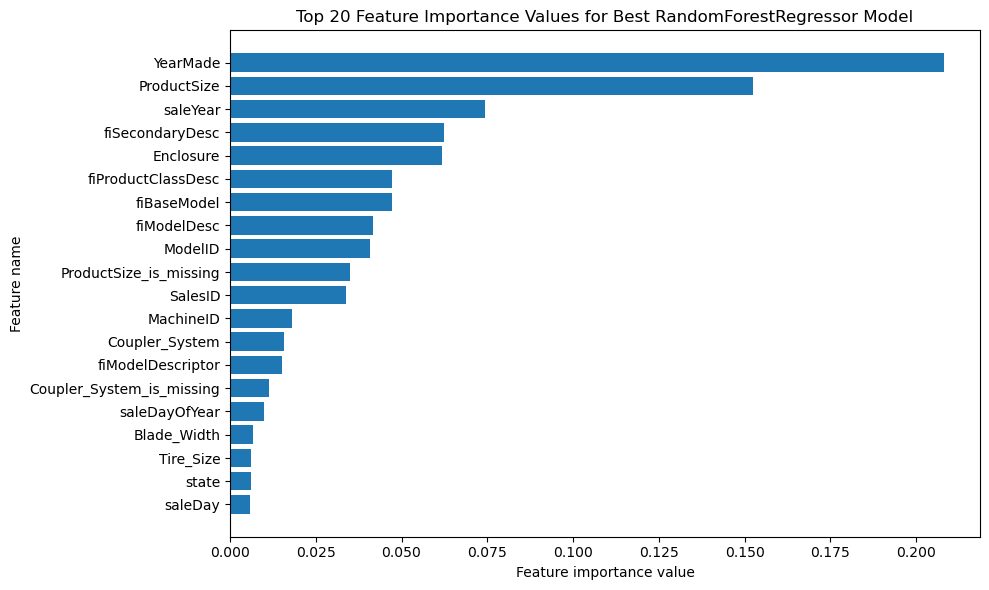

In [518]:
plot_features(X_train.columns, ideal_model.feature_importances_, title="Top 20 Feature Importance Values for Best RandomForestRegressor Model")


In [516]:
df["Enclosure"].value_counts()

Enclosure
OROPS                  177971
EROPS                  141769
EROPS w AC              92601
EROPS AC                   18
NO ROPS                     3
None or Unspecified         2
Name: count, dtype: int64